# Assignment 2: Local Feature Matching

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from skimage import filters, feature, img_as_int
from skimage.measure import regionprops
from skimage import io, filters, feature, img_as_float32
from skimage.transform import rescale
from skimage.color import rgb2gray
from sklearn.metrics.pairwise import euclidean_distances
from skimage.feature import plot_matches, peak_local_max

In [2]:
# %load code/visualize

def show_correspondences(imgA, imgB, X1, Y1, X2, Y2, matches, mode='arrows', filename=None):
	'''
		Visualizes corresponding points between two images, either as
		arrows or dots

		mode='dots': Corresponding points will have the same random color
		mode='arrows': Corresponding points will be joined by a line

		Writes out a png of the visualization if 'filename' is not None.
	'''

	# generates unique figures so students can
	# look at all three at once
	fig, ax = plt.subplots(nrows=1, ncols=1)

	if mode == 'dots':
		print("dot visualization not implemented yet :(")

	else:
		kp1 = zip_x_y(Y1, X1)
		kp2 = zip_x_y(Y2, X2)
		matches = matches.astype(int)
		plot_matches(ax, imgA, imgB, kp1, kp2, matches)

	plt.show()

	if filename:
		plt.savefig(filename)

	return

def zip_x_y(x, y):
	zipped_points = []
	for i in range(len(x)):
		zipped_points.append(np.array([x[i], y[i]]))
	return np.array(zipped_points)


In [3]:
# %load code/helpers.py
# A set of helpers which are useful for debugging SIFT!
# Feel free to take a look around in case you are curious,
# but you shouldn't need to know exactly what goes on,
# and you certainly don't need to change anything

import scipy.io as scio
import numpy as np

# Gives you the TA solution for the interest points you
# are attempting to find
def cheat_interest_points(eval_file, scale_factor):

	file_contents = scio.loadmat(eval_file)

	x1 = file_contents['x1']
	y1 = file_contents['y1']
	x2 = file_contents['x2']
	y2 = file_contents['y2']

	x1 = x1 * scale_factor
	y1 = y1 * scale_factor
	x2 = x2 * scale_factor
	y2 = y2 * scale_factor

	return x1, y1, x2, y2



def evaluate_correspondence(img_A, img_B, ground_truth_correspondence_file,
	scale_factor, x1_est, y1_est, x2_est, y2_est, matches, confidences, vis, filename="eval_corr.jpg"):

	# Sort the matches by their confidences into descending order of confidence 
	# (high confidence at low array index)
	conf_sorted = -np.sort(-confidences, kind='mergesort')
	conf_indices = np.argsort(-confidences, kind='mergesort')
	matches = matches[conf_indices,:]
	confidences = conf_sorted

	# 'unscale' interest points to compare with ground truth points
	x1_est_scaled = x1_est / scale_factor
	y1_est_scaled = y1_est / scale_factor
	x2_est_scaled = x2_est / scale_factor
	y2_est_scaled = y2_est / scale_factor

	# We want to see how good our matches are;
	# extract the coordinates of each matched point

	x1_matches = np.zeros(matches.shape[0])
	y1_matches = np.zeros(matches.shape[0])
	x2_matches = np.zeros(matches.shape[0])
	y2_matches = np.zeros(matches.shape[0])

	for i in range(matches.shape[0]):

		x1_matches[i] = x1_est_scaled[int(matches[i, 0])]
		y1_matches[i] = y1_est_scaled[int(matches[i, 0])]
		x2_matches[i] = x2_est_scaled[int(matches[i, 1])]
		y2_matches[i] = y2_est_scaled[int(matches[i, 1])]

	good_matches = np.zeros((matches.shape[0],1))

	# Loads `ground truth' positions x1, y1, x2, y2
	file_contents = scio.loadmat(ground_truth_correspondence_file)

	# x1, y1, x2, y2 = scio.loadmat(eval_file)
	x1 = file_contents['x1']
	y1 = file_contents['y1']
	x2 = file_contents['x2']
	y2 = file_contents['y2']

	uniqueness_dist = 150
	good_match_dist = 150

	good_match_counter = 0
	bad_match_counter = 0
	top_100_counter = 0

	# Used to keep track of which TA points the student has matched
	# to so the student only gets credit for matching a TA point once
	correct_matches = np.zeros(x2.shape[0])

	# for each ground truth point in image 1
	for i in range(x1.shape[0]):

		# 1. find the student points within uniqueness_dist pixels of the ground truth point
		x_dists = x1_matches - x1[i]
		y_dists = y1_matches - y1[i]

		# computes distances of each interest point to the ground truth point
		dists = np.sqrt(np.power(x_dists, 2.0) + np.power(y_dists, 2.0))

		# get indices of points where distance is < uniqueness_dist
		close_to_truth = dists < uniqueness_dist

		# 2. get the points in image1 and their corresponding matches in image2
		image1_x = x1_matches[close_to_truth]
		image1_y = y1_matches[close_to_truth]
		image2_x = x2_matches[close_to_truth]
		image2_y = y2_matches[close_to_truth]

		# 3. compute the distance of the student's image2 matches to the ground truth match
		x_dists_2 = image2_x - x2[i]
		y_dists_2 = image2_y - y2[i]

		dists_2 = np.sqrt(np.power(x_dists_2, 2.0) + np.power(y_dists_2, 2.0))

		# 4. matches within good_match_dist then count it as a correct match
		good = dists_2 < good_match_dist
		if np.sum(good) >= 1.0:
			correct_matches[i] = 1
			#good_match_counter += 1
			if i < 100:
				top_100_counter += 1
		else:
			bad_match_counter += 1

	precision = (np.sum(correct_matches) / x2.shape[0]) * 100.0
	accuracy100 = min(top_100_counter,100) # / 100) * 100# If we were testing more than the top 100, then this would be important.

	print(str(np.sum(correct_matches)) + " total good matches, " + str(bad_match_counter) + " total bad matches.")
	print(str(precision) + "% precision")
	print(str(accuracy100) + "% accuracy (top 100)")

	if vis > 0:
		print("Vizualizing...")
		# Rescale the points to the scaled input
		show_correspondences(img_A, img_B, \
				x1_est, y1_est, \
				x2_est, y2_est, \
				matches, filename)

	return accuracy100


## Part 1: Detection

In [4]:
def get_interest_points(image, feature_width):
    '''
    Returns a set of interest points for the input image

    (Please note that we recommend implementing this function last and using cheat_interest_points()
    to test your implementation of get_features() and match_features())

    Implement the Harris corner detector (See Szeliski 4.1.1) to start with.
    You do not need to worry about scale invariance or keypoint orientation estimation
    for your Harris corner detector.
    You can create additional interest point detector functions (e.g. MSER)
    for extra credit.

    If you're finding spurious (false/fake) interest point detections near the boundaries,
    it is safe to simply suppress the gradients / corners near the edges of
    the image.

    Useful functions: A working solution does not require the use of all of these
    functions, but depending on your implementation, you may find some useful. Please
    reference the documentation for each function/library and feel free to come to hours
    or post on Piazza with any questions

        - skimage.feature.peak_local_max
        - skimage.measure.regionprops


    :params:
    :image: a grayscale or color image (your choice depending on your implementation)
    :feature_width:

    :returns:
    :xs: an np array of the x coordinates of the interest points in the image
    :ys: an np array of the y coordinates of the interest points in the image

    :optional returns (may be useful for extra credit portions):
    :confidences: an np array indicating the confidence (strength) of each interest point
    :scale: an np array indicating the scale of each interest point
    :orientation: an np array indicating the orientation of each interest point

    '''
    
    k = 0.04
    threshold = 0.01
    
    y_grad = filters.sobel_v(image)
    x_grad = filters.sobel_h(image)
    
    Ixx = np.square(x_grad)
    Ixy = x_grad * y_grad
    Iyy = np.square(y_grad)
    
    xs = []
    ys = []
    
    Ixx = filters.gaussian(Ixx, sigma=2)
    Iyy = filters.gaussian(Iyy, sigma=2)
    Ixy = filters.gaussian(Ixy, sigma=2)
    
    a, b = image.shape
    r = np.zeros_like(image)
    
    # Get matrix of R values
    for i in range(a):
        for j in range(b):
            m = np.array([[Ixx[i, j], Ixy[i, j]], [Ixy[i, j], Iyy[i, j]]])
            r[i, j] = np.linalg.det(m) - k * np.square(np.trace(m))
                
    peaks = peak_local_max(r, threshold_rel = threshold, indices = True)
    
    xs = peaks[:,0].reshape(-1, 1)
    ys = peaks[:,1].reshape(-1, 1)

    return ys, xs

## Part 2: Description

In [5]:
def get_features(image, x, y, feature_width):
    '''
    Returns a set of feature descriptors for a given set of interest points.

    (Please note that we reccomend implementing this function after you have implemented
    match_features)

    To start with, you might want to simply use normalized patches as your
    local feature. This is very simple to code and works OK. However, to get
    full credit you will need to implement the more effective SIFT-like descriptor
    (See Szeliski 4.1.2 or the original publications at
    http://www.cs.ubc.ca/~lowe/keypoints/)

    Your implementation does not need to exactly match the SIFT reference.
    Here are the key properties your (baseline) descriptor should have:
    (1) a 4x4 grid of cells, each descriptor_window_image_width/4.
    (2) each cell should have a histogram of the local distribution of
        gradients in 8 orientations. Appending these histograms together will
        give you 4x4 x 8 = 128 dimensions.
    (3) Each feature should be normalized to unit length

    You do not need to perform the interpolation in which each gradient
    measurement contributes to multiple orientation bins in multiple cells
    As described in Szeliski, a single gradient measurement creates a
    weighted contribution to the 4 nearest cells and the 2 nearest
    orientation bins within each cell, for 8 total contributions. This type
    of interpolation probably will help, though.

    You do not have to explicitly compute the gradient orientation at each
    pixel (although you are free to do so). You can instead filter with
    oriented filters (e.g. a filter that responds to edges with a specific
    orientation). All of your SIFT-like feature can be constructed entirely
    from filtering fairly quickly in this way.

    You do not need to do the normalize -> threshold -> normalize again
    operation as detailed in Szeliski and the SIFT paper. It can help, though.

    Another simple trick which can help is to raise each element of the final
    feature vector to some power that is less than one.

    Useful functions: A working solution does not require the use of all of these
    functions, but depending on your implementation, you may find some useful. Please
    reference the documentation for each function/library and feel free to come to hours
    or post on Piazza with any questions

        - skimage.filters (library)


    :params:
    :image: a grayscale or color image (your choice depending on your implementation)
    :x: np array of x coordinates of interest points
    :y: np array of y coordinates of interest points
    :feature_width: in pixels, is the local feature width. You can assume
                    that feature_width will be a multiple of 4 (i.e. every cell of your
                    local SIFT-like feature will have an integer width and height).
    If you want to detect and describe features at multiple scales or
    particular orientations you can add input arguments.

    :returns:
    :features: np array of computed features. It should be of size
            [len(x) * feature dimensionality] (for standard SIFT feature
            dimensionality is 128)

    '''

    # Get a feature_width x feature_width patch around each descriptor
    assert feature_width % 4 == 0
    
    # x and y have double values
    l = x.shape[0] # get number of points
    
    # get gradients at each pixel
    grad_x = filters.sobel_h(image)
    grad_y = filters.sobel_v(image)
    grad_mag = np.sqrt(np.square(grad_x) + np.square(grad_y)) 
    grad_ori = np.arctan2(grad_y, grad_x)
    
    features = []
    
    for i in range(l): # iterate over each keypoint
        assert x[i, 0] < image.shape[1]
        assert y[i, 0] < image.shape[0]
        
        # get patch
        patch = image[max(0, int(np.floor(y[i, 0]) - feature_width / 2)):min(image.shape[0] - 1, int(np.floor(y[i, 0]) + feature_width / 2)), 
                    max(0, int(np.floor(x[i, 0]) - feature_width / 2)):min(image.shape[1] - 1, int(np.floor(x[i, 0]) + feature_width / 2))]
        
        # get orientations of the patch
        ori_patch = grad_ori[max(0, int(np.floor(y[i, 0]) - feature_width / 2)):min(image.shape[0] - 1, int(np.floor(y[i, 0]) + feature_width / 2)), 
                    max(0, int(np.floor(x[i, 0]) - feature_width / 2)):min(image.shape[1] - 1, int(np.floor(x[i, 0]) + feature_width / 2))]

        if ori_patch.shape != (16, 16):
            continue
        
        # construct histogram for each 4x4 cell in the patch
        descriptor = []

        for j in range(0, int(feature_width / 4)):
            for k in range(0, int(feature_width / 4)):
                a, b = j * 4, k * 4
                c, d = (j + 1) * 4, (k + 1) * 4
                
                # construct 8-bin histogram for the 4x4 patch
                hist = np.zeros(8)
                for m in range(a, c):
                    for n in range(b, d):
                        if ori_patch[m, n] < 0:
                            bin_index = int(((2 * np.pi) + ori_patch[m, n]) * 8 / (2 * np.pi))
                        else:
                            bin_index = int(ori_patch[m, n] * 8 / (2 * np.pi))
                            
                        hist[bin_index] += 1
                        
                descriptor.append(hist)
                
        descriptor = np.array(descriptor).reshape(-1, 1)
        descriptor = descriptor / np.linalg.norm(descriptor)
        # Accuracy goes down after clamping values :(
        
        features.append(descriptor)
        
    features = np.squeeze(np.array(features))

    return features

## Part 3: Matching

In [6]:
def match_features(im1_features, im2_features):
    '''
    Implements the Nearest Neighbor Distance Ratio Test to assign matches between interest points
    in two images.

    Please implement the "Nearest Neighbor Distance Ratio (NNDR) Test" ,
    Equation 4.18 in Section 4.1.3 of Szeliski.

    For extra credit you can implement spatial verification of matches.

    Please assign a confidence, else the evaluation function will not work. Remember that
    the NNDR test will return a number close to 1 for feature points with similar distances.
    Think about how confidence relates to NNDR.

    This function does not need to be symmetric (e.g., it can produce
    different numbers of matches depending on the order of the arguments).

    A match is between a feature in im1_features and a feature in im2_features. We can
    represent this match as a the index of the feature in im1_features and the index
    of the feature in im2_features

    Useful functions: A working solution does not require the use of all of these
    functions, but depending on your implementation, you may find some useful. Please
    reference the documentation for each function/library and feel free to come to hours
    or post on Piazza with any questions

        - zip (python built in function)

    :params:
    :im1_features: an np array of features returned from get_features() for interest points in image1
    :im2_features: an np array of features returned from get_features() for interest points in image2

    :returns:
    :matches: an np array of dimension k x 2 where k is the number of matches. The first
            column is an index into im1_features and the second column is an index into im2_features
    :confidences: an np array with a real valued confidence for each match
    '''

    matches = []
    confidences = []
    
    threshold = 0.8
    
    distances = euclidean_distances(im1_features, im2_features)
    dist_h, dist_w = distances.shape
    
    # Find the minimum and second minimum distance in each row
    for i in range(dist_h):
        mini = 10000.0
        mini2 = 10000.0

        mini_idx = []
        
        for j in range(dist_w):
            if distances[i, j] < mini:
                mini2 = mini
                mini = distances[i, j]

                mini_idx = [i, j]

        nndr = mini/mini2

        if nndr < threshold: # match
            # add to matches array
            matches.append(mini_idx)

            confidence = 1 - nndr # Assume that this is a reasonable confidence measure
            confidences.append(confidence)
        
    matches = np.array(matches)
    confidences = np.array(confidences)

    return matches, confidences

In [7]:
def load_data(file_name):
    """
    1) Load stuff
    There are numerous other image sets in the supplementary data on the
    project web page. You can simply download images off the Internet, as
    well. However, the evaluation function at the bottom of this script will
    only work for three particular image pairs (unless you add ground truth
    annotations for other image pairs). It is suggested that you only work
    with the two Notre Dame images until you are satisfied with your
    implementation and ready to test on additional images. A single scale
    pipeline works fine for these two images (and will give you full credit
    for this project), but you will need local features at multiple scales to
    handle harder cases.

    If you want to add new images to test, create a new elif of the same format as those
    for notre_dame, mt_rushmore, etc. You do not need to set the eval_file variable unless
    you hand create a ground truth annotations. To run with your new images use
    python main.py -p <your file name>.

    :param file_name: string for which image pair to compute correspondence for

        The first three strings can be used as shortcuts to the
        data files we give you

        1. notre_dame
        2. mt_rushmore
        3. e_gaudi

    :return: a tuple of the format (image1, image2, eval file)
    """

    # Note: these files default to notre dame, unless otherwise specified
    image1_file = "./data/NotreDame/NotreDame1.jpg"
    image2_file = "./data/NotreDame/NotreDame2.jpg"

    eval_file = "./data/NotreDame/NotreDameEval.mat"

    if file_name == "notre_dame":
        pass
    elif file_name == "mt_rushmore":
        image1_file = "./data/MountRushmore/Mount_Rushmore1.jpg"
        image2_file = "./data/MountRushmore/Mount_Rushmore2.jpg"
        eval_file = "./data/MountRushmore/MountRushmoreEval.mat"
    elif file_name == "e_gaudi":
        image1_file = "./data/EpiscopalGaudi/EGaudi_1.jpg"
        image2_file = "./data/EpiscopalGaudi/EGaudi_2.jpg"
        eval_file = "./data/EpiscopalGaudi/EGaudiEval.mat"

    image1 = img_as_float32(io.imread(image1_file))
    image2 = img_as_float32(io.imread(image2_file))

    return image1, image2, eval_file

/Users/pascalewalters/miniconda2/envs/blah/lib/python3.7/site-packages/skimage/transform/_warps.py:23: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '


Getting interest points...


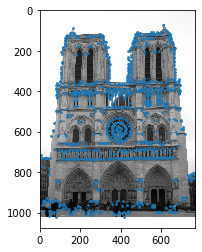

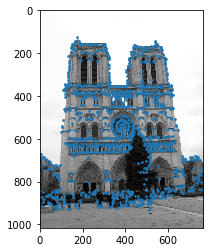

Done!
Getting features...
Done!
Matching features...
Done!
Matches: 108
79.0 total good matches, 70 total bad matches.
53.02013422818792% precision
50% accuracy (top 100)
Vizualizing...


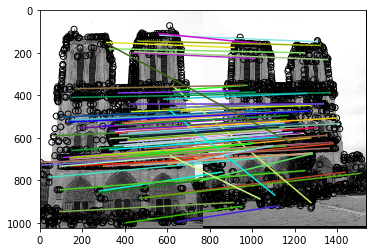

In [8]:
# Include this flag to compute the average accuracy of your matching
average_accuracy = False
# Either notre_dame, mt_rushmore, or e_gaudi. Specifies which image pair to match
pair = 'notre_dame'

# (1) Load in the data
image1, image2, eval_file = load_data(pair)

# You don't have to work with grayscale images. Matching with color
# information might be helpful. If you choose to work with RGB images, just
# comment these two lines
image1 = rgb2gray(image1)
image2 = rgb2gray(image2)

# make images smaller to speed up the algorithm. This parameter
# gets passed into the evaluation code, so don't resize the images
# except for changing this parameter - We will evaluate your code using
# scale_factor = 0.5, so be aware of this
scale_factor = 0.5

# Bilinear rescaling
image1 = np.float32(rescale(image1, scale_factor))
image2 = np.float32(rescale(image2, scale_factor))

# width and height of each local feature, in pixels
feature_width = 16

# (2) Find distinctive points in each image. See Szeliski 4.1.1
# !!! You will need to implement get_interest_points. !!!

print("Getting interest points...")

# For development and debugging get_features and match_features, you will likely
# want to use the ta ground truth points, you can comment out the precedeing two
# lines and uncomment the following line to do this.

(x1, y1) = get_interest_points(image1, feature_width)
(x2, y2) = get_interest_points(image2, feature_width)

# # From helpers.py
# (x1, y1, x2, y2) = cheat_interest_points(eval_file, scale_factor)

# if you want to view your corners uncomment these next lines!

plt.imshow(image1, cmap="gray")
plt.scatter(x1, y1, alpha=0.9, s=3)
plt.show()

plt.imshow(image2, cmap="gray")
plt.scatter(x2, y2, alpha=0.9, s=3)
plt.show()

print("Done!")

# 3) Create feature vectors at each interest point. Szeliski 4.1.2
# !!! You will need to implement get_features. !!!

print("Getting features...")
image1_features = get_features(image1, x1, y1, feature_width)
image2_features = get_features(image2, x2, y2, feature_width)

print("Done!")

# 4) Match features. Szeliski 4.1.3
# !!! You will need to implement match_features !!!

print("Matching features...")
matches, confidences = match_features(image1_features, image2_features)

if len(matches.shape) == 1:
    print( "No matches!")

print("Done!")

# 5) Visualization

# You might want to do some preprocessing of your interest points and matches
# before visualizing (e.g. only visualizing 100 interest points). Once you
# start detecting hundreds of interest points, the visualization can become
# crowded. You may also want to threshold based on confidence

# visualize.show_correspondences produces a figure that shows your matches
# overlayed on the image pairs. evaluate_correspondence computes some statistics
# about the quality of your matches, then shows the same figure. If you want to
# just see the figure, you can uncomment the function call to visualize.show_correspondences


num_pts_to_visualize = matches.shape[0]
print("Matches: " + str(num_pts_to_visualize))
# visualize.show_correspondences(image1, image2, x1, y1, x2, y2, matches, filename=pair + "_matches.jpg")

## 6) Evaluation
# This evaluation function will only work for the Notre Dame, Episcopal
# Gaudi, and Mount Rushmore image pairs. Comment out this function if you
# are not testing on those image pairs. Only those pairs have ground truth
# available.
#
# It also only evaluates your top 100 matches by the confidences
# that you provide.
#
# Within evaluate_correspondences(), we sort your matches in descending order
#
num_pts_to_evaluate = matches.shape[0]

if num_pts_to_evaluate != 0:
    evaluate_correspondence(image1, image2, eval_file, scale_factor,
        x1, y1, x2, y2, matches, confidences, num_pts_to_visualize)
